# Atividade 3 - Análise de componentes principais (PCA)

Nesta atividade iremos analisar a nossa base de dados utilizando a técnica de Análise de Componentes Principais com a finalidade de entender como os dados da nossa base se comportam e como podemos aplicar uma técnica de redução dimensional nela.

## Relembrando o nosso dataset

Para o nosso trabalhos, estamos utilizando o dataset [Grammatical Facial Expressions](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions), que descreve expressões faciais gramaticais da linguagem brasileira de sinais (Libras).

A base possui `27965 instâncias`, subdivididas em 9 expressões: `Interrogativa (qu)`,`Interrogativa (s/n)`, `Interrogativa (dúvida)`, `Negativa`, `Afirmativa`, `Condicional`, `Relativa`, `Tópico` e `Foco`. 

Cada instância é estruturada em `300 características`, que representam 100 pontos com coordenadas (x, y, z) da face. Não há missing values nesses pontos e eles não por um processo de normalização.

A classificação de instância é binária onde ela pode ser "Com Expressão" ("Expression", onde os pontos representam a expressão facial) ou "Sem Expressão" ("Not Expression", os pontos não representam uma expressão).

Visualizando todas as instâncias da base, podemos identificar a quantidade de instâncias por expressão e classe na tabela abaixo:

In [1]:
from scripts.database import all_categories_database_instance_description
all_categories_database_instance_description()

,Facial Expression,"""Expression"" Instances","""Expression"" Instance Proportion","""Not Expression"" Instances","""Not Expression"" Instance Proportion",Total Instances
0,wh_question,1158,0.442999,1456,0.557001,2614
1,yn_question,1247,0.398657,1881,0.601343,3128
2,doubt_question,1271,0.452474,1538,0.547526,2809
3,negative,1240,0.458241,1466,0.541759,2706
4,affirmative,942,0.441011,1194,0.558989,2136
5,conditional,1137,0.288505,2804,0.711495,3941
6,relative,1194,0.282003,3040,0.717997,4234
7,topics,827,0.228390,2794,0.771610,3621
8,emphasis,861,0.313433,1886,0.686567,2747


Observando a proporção de classes em relação ao total de instâncias, podemos perceber que as expressões com bases mais próximas de balanceadas (i.e., tem proporção de classes positivas e negativas parecidas) são: `wh_question`, `doubt_question`, `negative` e `affirmative`.

Nesta atividade iremos aplicar o PCA somente nos dados da expressão `negative`.

## Análise de componentes principais (PCA, Principal Component Analysis)

Na análise de componentes principais buscamos converter as variáveis de um conjunto de dados, possivelmente correlacionadas, através de uma transformação ortogonal em novas variáveis não correlacionadas sob uma nova base de coordenadas, os componentes principais, de forma que os primeiros componentes representem grande parte da variância do conjunto de dados inicial.

Neste estudo utilizaremos a biblioteca [sklearn](https://scikit-learn.org/stable/) do Python que já possui a técnica PCA [previamente implementada](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).

Iremos aplica-la nos dados 2 vezes: 
- uma com os dados brutos, simulando o PCA utilizando a matriz de covariância dos dados;
- outra com os dados normalizados, simulando o PCA utilizando a matriz de correlação dos dados.

E para efeito de redução de dimensões, iremos considerar todos os componentes que representem até 80% da variância dos dados originais.

Na implementação buscamos aplicar o PCA no conjunto de dados de forma a obter a base transformada, os componentes principais e as estatísticas da técnica:

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd

# maxima variância esperada
PCA_THRESHOLD = 80.0

def principal_component_analysis(features, X):
    """Calcula o PCA com o sklearn"""
    pca = PCA()
    X_transformed = pca.fit_transform(X)

    component_names = list(map(lambda i : f'PC{i}', range(1, len(features) + 1)))
    
    # como o PCA do sklearn utiliza SVD, ao invés de ele nos retornar os autovalores (eigenvalues),
    # ele nos retorna valores singulares (singular values), que precisam ser convertidos para autovalores
    # referência: https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
    eigenvalues = pd.Series(data=(pca.singular_values_ ** 2) / (len(X)), index=component_names)
    variance_ratio = pd.Series(data=pca.explained_variance_ratio_ * 100, index=component_names)
    
    pca_stats = pd.DataFrame(data={
        'Eigenvalues': eigenvalues,
        'Variance %': variance_ratio,
        'Cum. Eigenvalues': eigenvalues.cumsum(),
        'Cum. Variance %': variance_ratio.cumsum()
    })

    principal_components = pd.DataFrame(data=pca.components_.T, columns=component_names, index=features)
    
    # encontra o PC que faz ultrapassa o limiar 
    threshold_expression = pca_stats['Cum. Variance %'] >= PCA_THRESHOLD
    threshold_index = pca_stats[threshold_expression].head(1).index.values

    # mostra todos os pcs dentro do limiar mais o primeiro que passou o limiar
    principal_components_under_threshold = list(pca_stats[~threshold_expression].index.values) + list(threshold_index)
    
    return pca_stats, principal_components, principal_components_under_threshold, X_transformed

### Aplicando o PCA para a expressão `negative`

Em um primeiro momento carregamos os dados da categoria `negative` para utilizar nos algoritmos e calculamos algumas medidas de estatística descritiva da base para termos uma idéia da distribuição de dados de cada variável (neste caso dimensão do ponto).

In [3]:
from scripts.database import load_datapoints, load_targets

category = 'negative'
data = load_datapoints(category)
targets = load_targets(category)

features = list(data.columns)

data.describe()

,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,...,96z,97x,97y,97z,98x,98y,98z,99x,99y,99z
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,309.397827,219.230181,1060.284922,306.747875,217.450552,1131.164819,303.378426,216.894622,1193.764597,300.074385,...,1264.941981,336.213900,205.329225,1272.370658,341.628362,207.474289,1184.382114,344.936643,210.218903,986.881744
std,10.612048,14.874460,439.370887,10.614432,15.017886,361.558210,10.643030,15.185494,266.930040,10.749632,...,85.920339,8.731956,13.120294,89.417381,8.828361,12.035667,351.531081,9.283779,11.350090,555.178027
min,284.689000,180.156000,0.000000,281.267000,177.075000,0.000000,276.624000,176.110000,0.000000,272.141000,...,0.000000,316.827000,160.573000,0.000000,321.877000,164.759000,0.000000,325.012000,169.715000,0.000000
25%,298.539250,201.938750,1216.000000,295.935750,199.979500,1221.000000,292.494250,199.242250,1225.000000,288.968250,...,1252.000000,328.490000,190.455000,1265.000000,333.771500,193.954250,1275.000000,336.410250,197.584000,1208.000000
50%,312.030000,229.251000,1238.000000,309.420500,227.463000,1243.000000,306.307000,227.081500,1256.000000,303.322500,...,1275.000000,335.835000,213.641500,1284.000000,341.306000,214.365500,1294.000000,345.151000,216.028000,1294.000000
75%,317.974750,231.949000,1261.000000,315.219000,230.355250,1270.000000,311.805000,229.977750,1280.000000,308.526750,...,1289.000000,342.709500,216.596250,1294.000000,348.130500,217.373750,1299.000000,351.981750,219.523500,1309.000000
max,331.248000,239.845000,1299.000000,328.514000,238.110000,1304.000000,325.127000,237.517000,1314.000000,321.947000,...,1319.000000,356.602000,223.180000,1329.000000,362.141000,223.940000,1542.000000,365.228000,225.527000,1563.000000


Em seguida aplicamos o PCA nos dados brutos simulando a decomposição da matriz de covariância e identificando todos os componentes principais que representam até 80% da variância dos dados. Nesta base, encontramos 14 componentes principais, que representam 81,60% da variância da base de dados.

In [4]:
# PCA com dados brutos (equivalente ao cálculo com matriz de covariância)
X = data.values
pca_stats, principal_components, principal_components_under_threshold, X_transformed = principal_component_analysis(features, X)

pca_stats[pca_stats.index.isin(principal_components_under_threshold)]

,Eigenvalues,Variance %,Cum. Eigenvalues,Cum. Variance %
PC1,2.366309e+06,32.230159,2.366309e+06,32.230159
PC2,6.872079e+05,9.360071,3.053517e+06,41.590230
PC3,5.684479e+05,7.742508,3.621965e+06,49.332738
PC4,3.920549e+05,5.339958,4.014020e+06,54.672695
PC5,2.982401e+05,4.062160,4.312260e+06,58.734855
PC6,2.852202e+05,3.884823,4.597480e+06,62.619679
PC7,2.458860e+05,3.349074,4.843366e+06,65.968753
PC8,1.966818e+05,2.678891,5.040048e+06,68.647644
PC9,1.955887e+05,2.664003,5.235636e+06,71.311647
PC10,1.745645e+05,2.377645,5.410201e+06,73.689292


In [5]:
principal_components[principal_components_under_threshold]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0x,0.005791,-0.002279,0.000921,0.002314,0.001425,-0.000836,-0.001211,0.000517,0.000145,0.000122,-0.000149,0.001840,-0.001057,-0.000030
0y,0.008503,0.000365,-0.000625,0.001404,-0.000292,0.000643,-0.002294,-0.001481,0.000279,-0.003954,0.001396,0.001635,0.000689,-0.002361
0z,-0.107522,-0.292714,-0.223337,0.029103,0.076311,0.087084,0.083425,-0.198367,0.136564,-0.219903,-0.020572,0.234436,0.045562,0.050287
1x,0.005788,-0.002206,0.000905,0.002306,0.001422,-0.000788,-0.001185,0.000532,0.000187,0.000127,-0.000217,0.001835,-0.001057,-0.000015
1y,0.008573,0.000463,-0.000700,0.001354,-0.000475,0.000573,-0.002311,-0.001508,0.000260,-0.004132,0.001442,0.001673,0.000734,-0.002422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98y,0.006805,0.000131,0.000035,0.001689,0.001470,0.000289,-0.001924,-0.000515,0.000295,-0.001942,0.000561,0.001474,-0.000221,-0.000754
98z,0.090234,-0.006447,-0.033585,-0.183650,0.018859,-0.004262,0.004958,0.021145,-0.047494,-0.354305,-0.141477,-0.321134,0.000625,0.115308
99x,0.004694,-0.003157,0.001228,0.002137,0.002403,-0.001258,-0.001524,0.000856,-0.000037,0.000391,0.000243,0.001388,-0.000818,0.000177
99y,0.006360,-0.000044,0.000207,0.001694,0.001928,0.000362,-0.001861,-0.000347,0.000340,-0.001658,0.000379,0.001405,-0.000332,-0.000602


No gráfico podemos observar uma das características do PCA: a cada componente principal que consideramos na nossa base, mais da variância vai sendo explicado até chegarmos no nosso limite de 80% da variância explicada.

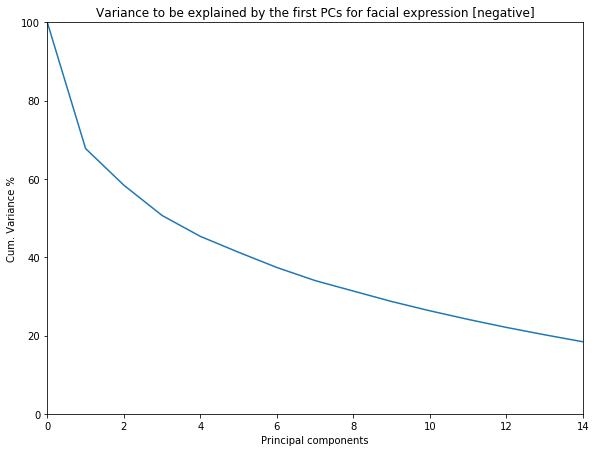

In [6]:
import matplotlib.pyplot as plt

threshold_stats = pca_stats[pca_stats.index.isin(principal_components_under_threshold)]
plot_y = [ 100.0 ] + list(100.0 - threshold_stats['Cum. Variance %'].values)
plot_x = list(range(0, len(plot_y)))

plt.figure(figsize=[6.4 * 1.5, 4.8 * 1.5])
plt.axis([0, len(plot_y) - 1, 0, 100])
plt.ylabel('Cum. Variance %')
plt.xlabel('Principal components')
plt.title(f'Variance to be explained by the first PCs for facial expression [{category}]')
plt.plot(plot_x, plot_y)
plt.show()

Por fim, podemos projetar as instâncias da base de dados contra os 3 primeiros componentes principais e entender o quanto os dados estão divididos nesse novo sistema de coordenadas. Neste caso, as classes ainda se sobrepoem de maneira igual no espaço.

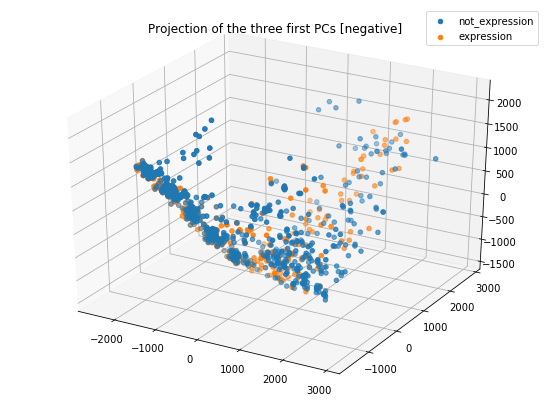

In [7]:
from mpl_toolkits import mplot3d

reduced_X = X_transformed[:, 0:len(principal_components_under_threshold)]

not_expression = reduced_X[targets[targets['target'] == 0].index.values, :]
expression = reduced_X[targets[targets['target'] == 1].index.values, :]

fig = plt.figure(figsize=[6.4 * 1.5, 4.8 * 1.5])
ax = fig.add_subplot(111, projection='3d')

ax.scatter(not_expression[:, 0], not_expression[:, 1], not_expression[:, 2], c = '#1f77b4')
ax.scatter(expression[:, 0], expression[:, 1], expression[:, 2], c = '#ff7f0e')

plt.legend(['not_expression', 'expression'])
plt.title(f'Projection of the three first PCs [{category}]')
plt.show()

Aplicando o PCA com os dados normalizados pelo `StandardScaler` encontramos 5 componentes principais que representam 80% da variância dos dados.

In [8]:
# PCA com dados normalizados (equivalente ao cálculo com matriz de correlação)
normalized_X = StandardScaler().fit_transform(X)
normalized_pca_stats, normalized_principal_components, normalized_principal_components_under_threshold, normalized_X_transformed = principal_component_analysis(features, normalized_X)

normalized_pca_stats[normalized_pca_stats.index.isin(normalized_principal_components_under_threshold)]

,Eigenvalues,Variance %,Cum. Eigenvalues,Cum. Variance %
PC1,197.016257,65.672086,197.016257,65.672086
PC2,23.985747,7.995249,221.002004,73.667335
PC3,12.240866,4.080289,233.242870,77.747623
PC4,4.626893,1.542298,237.869763,79.289921
PC5,2.620769,0.873590,240.490532,80.163511


In [9]:
normalized_principal_components[normalized_principal_components_under_threshold]

,PC1,PC2,PC3,PC4,PC5
0x,-0.068750,-0.003949,0.068943,0.034549,-0.011288
0y,-0.069004,0.014631,-0.064966,-0.022566,-0.008204
0z,0.019545,-0.008254,0.082820,-0.227782,-0.152883
1x,-0.068721,-0.005022,0.067636,0.036895,-0.013091
1y,-0.068840,0.013415,-0.067687,-0.023762,-0.005922
...,...,...,...,...,...
98y,-0.069537,0.007457,-0.034662,0.016886,-0.032142
98z,-0.022127,0.007876,-0.052741,-0.040352,0.212148
99x,-0.064694,0.014318,0.107692,0.018836,-0.017007
99y,-0.069308,0.007846,-0.026895,0.022429,-0.042098


Na representação gráfica da explicação da variância pelos componentes principais podemos perceber que com a base normalizada temos um componente que representa grande parte da variância da base (cerca de 65% da variância), enquanto os outros componentes representam muito pouco dessa variância.

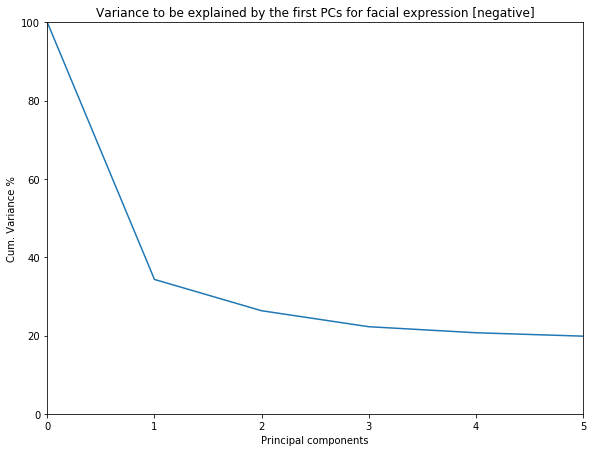

In [10]:
import matplotlib.pyplot as plt

normalized_threshold_stats = normalized_pca_stats[normalized_pca_stats.index.isin(normalized_principal_components_under_threshold)]
plot_y = [ 100.0 ] + list(100.0 - normalized_threshold_stats['Cum. Variance %'].values)
plot_x = list(range(0, len(plot_y)))

plt.figure(figsize=[6.4 * 1.5, 4.8 * 1.5])
plt.axis([0, len(plot_y) - 1, 0, 100])
plt.ylabel('Cum. Variance %')
plt.xlabel('Principal components')
plt.title(f'Variance to be explained by the first PCs for facial expression [{category}]')
plt.plot(plot_x, plot_y)
plt.show()

Já neste cenário onde os três primeiros PCs representam grande parte da variância da base (cerca de 77%), podemos ver uma divisão diferente dos nossos dados. Eles ainda se sobrepoem, mas é possível ver dois agrupamentos distintos entre eles.

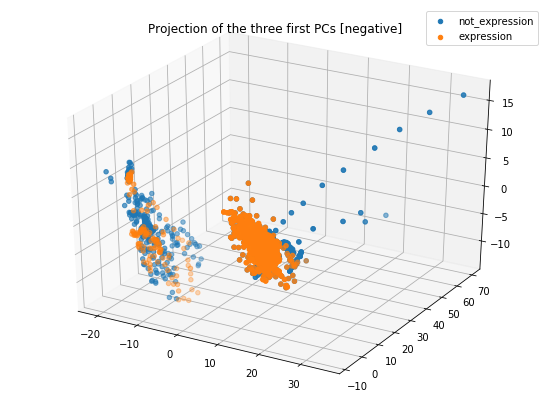

In [11]:
from mpl_toolkits import mplot3d

reduced_X = normalized_X_transformed[:, 0:len(normalized_principal_components_under_threshold)]

not_expression = reduced_X[targets[targets['target'] == 0].index.values, :]
expression = reduced_X[targets[targets['target'] == 1].index.values, :]

fig = plt.figure(figsize=[6.4 * 1.5, 4.8 * 1.5])
ax = fig.add_subplot(111, projection='3d')

ax.scatter(not_expression[:, 0], not_expression[:, 1], not_expression[:, 2], c = '#1f77b4')
ax.scatter(expression[:, 0], expression[:, 1], expression[:, 2], c = '#ff7f0e')

plt.legend(['not_expression', 'expression'])
plt.title(f'Projection of the three first PCs [{category}]')
plt.show()

## Próximos passos

No escopo desta atividade nos focamos em entender um pouco mais da base de dados e de aplicar o PCA neles. Como próximos passos podemos:

- Implementar na base de dados no eles um processo de normalização por translação para uma base em comum, como pode ser visto na página 65 de [Freitas, 2015](https://teses.usp.br/teses/disponiveis/100/100131/tde-10072015-100311/pt-br.php)
- Aplicar transformações na base de dados, como representá-la como as distâncias entre os pontos da face, os angulos que esses pontos formam, entre outros, e analisar se é possível discriminar melhor as instâncias entre as classes.